<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [3]:
url = "https://www.indeed.co.uk/jobs?q=data+scientist&l=London%2C+Greater+London&radius=5&start=0"

In [3]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import re
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Import up sound alert dependencies
from IPython.display import Audio, display
from playsound import playsound

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
from matplotlib.colors import ListedColormap


def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn



In [4]:
def alldone():
#     display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
    playsound('/System/Library/Sounds/Purr.aiff')
    playsound('/System/Library/Sounds/Purr.aiff')
    playsound('/System/Library/Sounds/Purr.aiff')
    
alldone()


In [57]:
# r = requests.get(url)

In [58]:
# soup = BeautifulSoup(r.text, 'html.parser')

In [59]:
# print(soup.prettify())

In [ ]:
# First search (not enough jobs)
# "data scientist" or "data engineer" or "business intelligence" or "data product manager" or "data analyst" or "data science" or "machine learning" or "data architect" or "data visualisation"

# second search (too many non-connected jobs)
# Data + Science or Data +Engineer or Data +Architect or Data+ Analyst or "business intelligence" or "data visualisation" or "data product" or "data architect" or "machine learning" £20,000

# Third search (like 1st search with better search)
# "data scientist" or "data engineer" or "business intelligence" or "data product manager" or "data analyst" or "data science" or "machine learning" or "data architect" or "data visualisation"


In [ ]:
# https://www.indeed.co.uk/jobs?q=Data+%2B+Science+or+Data+%2BEngineer+or+Data+%2BArchitect+or+Data%2B+Analyst+or+%22business+intelligence%22+or+%22data+visualisation%22+or+%22data+product%22+or+%22data+architect%22+or+%22machine+learning%22+%C2%A320,000


Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [202]:

def indeed_scraper(pages=10,url_set=None,category='All'):
    
    jobtitle = []
    company = []
    rating = []
    salary = []
    description = []
    date = []
    location = []
    
    if pages == "calc":
        r = requests.get(url_set)
        soup = BeautifulSoup(r.text, 'html.parser')
        pages = soup.find('div', attrs={'id':'searchCountPages'}).text
        pages = round(int(re.sub(r"[ Pageof,jobs]", "" , pages)[2:])/10)
        print(category, "pages run for:",pages)
        
    
    if url_set == None:
        print("Need url to run")
        return

    for x in tqdm_notebook(range(0, pages)):
        url_format = url_set+'&start={}'.format(x*10)
        r = requests.get(url_format)
        soup = BeautifulSoup(r.text, 'html.parser')
        
        for job in soup.find_all('div', attrs={'class':re.compile(r'^jobsearch-Serp.*unified.*')}):

            try:
                jobtitle.append(job.find('a', attrs={'class':'jobtitle turnstileLink'}).text.replace('\n',''))
                
            except:
                jobtitle.append(np.nan)

            try:
                company.append(job.find('span', attrs={'class':'company'}).text.replace('\n',''))
            except:
                company.append(np.nan)

            try:
                rating.append(job.find('span', attrs={'class':'ratingsContent'}).text.replace('\n',''))
            except:
                rating.append(np.nan)

            try:
                salary.append(job.find('span', attrs={'class':'salary no-wrap'}).text.replace('\n',''))
            except:
                salary.append(np.nan)

            try:
                description.append(job.find('div', attrs={'class':'summary'}).text.replace('\n',''))
            except:
                description.append(np.nan)

            try:
                date.append(job.find('span', attrs={'class':'date'}).text.replace('\n',''))
            except:
                date.append(np.nan)
                
#             try:
#                 location.append(job.find('span', attrs={'class':'location accessible-contrast-color-location'}).text)
#             except:
#                 location.append(np.nan)

    jobz = pd.DataFrame({'job_title': jobtitle,
                         'company': company,
                        'rating': rating,
                         'salary': salary,
                        'description': description,
                        'date': date,
                         #'location':location,
                        'category': category})
    return jobz



In [24]:
edin = indeed_scraper(3,"https://www.indeed.co.uk/jobs?q=Data+%2B+Science+or+Data+%2Bengineer+or+Data+%2Barchitect+or+Data%2B+Analyst+or+%22business+Intelligence%22+or+%22data+Visualisation%22+or+%22data+Product%22+or+%22data+Architect%22+or+%22machine+Learning%22+%C2%A320%2C000&l=Belfast")
# manc = indeed_scraper('calc',"https://www.indeed.co.uk/jobs?q=%22data+scientist%22+or+%22data+engineer%22+or+%22business+intelligence%22+or+%22data+product+manager%22+or+%22data+analyst%22+or+%22data+science%22+or+%22machine+learning%22+or+%22data+architect%22+or+%22data+visualisation%22&l=Manchester&radius=5")
# lon = pd.concat([lon,manc])


In [25]:
edin


,job_title,company,rating,salary,description,date,category
0,Risk & Compliance Analyst,Funds-Axis Limited,NaN,"£21,000 - £26,000 a year",Data upload and exception investigation.Commu...,Just posted,All
1,Engagement Executive,Firstsource Solutions UK,3.5,NaN,Oversee the site engagement budget and report...,12 days ago,All
2,Bike Courier,Just Eat,3.3,NaN,A smart phone with a data plan.You can work w...,30+ days ago,All
3,Data Management Analyst,Funds-Axis Limited,NaN,"£20,000 a year",The Data Management Analyst will be a member ...,30+ days ago,All
4,Business Analyst,Lynn Recruitment,NaN,"£25,000 a year","Analysing data from a range of systems, using...",6 days ago,All
5,Data Processing Analysis Officers - Lisburn x 2,Kennedy Recruitment,NaN,£12.63 an hour,Data Entry: 1 year (Preferred).An understandi...,11 days ago,All
6,"Cyber, Data Science, Sensing, Space Systems & ...",UK Government - Defence Science and Technology...,3.1,"£21,500 - £53,400 a year",Applying the latest thinking in data science ...,28 days ago,All
7,Data Scientist with Machine Learning,PwC,4.0,NaN,Demonstrable experience as a data scientist a...,26 days ago,All
8,Junior Data Analyst,PwC,4.0,NaN,The data analyst role will fall under the Dat...,30+ days ago,All
9,Market Data Business Analyst,CITI,3.9,NaN,Provide support to existing Market Data Busin...,30+ days ago,All


In [6]:
# manc.head(30)

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [26]:
# Creating UK dataframe
url_template = 'https://www.indeed.co.uk/jobs?q=%22data+scientist%22+or+%22data+engineer%22+or+%22business+intelligence%22+or+%22data+product+manager%22+or+%22data+analyst%22+or+%22data+science%22+or+%22machine+learning%22+or+%22data+architect%22+or+%22data+visualisation%22&l={}&radius=10'
pages_per_city = 'calc'  # Set this to calc in order to calculate the number of pages needed.


# code for looping through cities and extracting
for i, city in enumerate(['London', 'Birmingham', 'Manchester', 'Leeds', 'Liverpool','Cardiff',
                          'Newcastle+upon+Tyne', 'Sheffield', 'Nottingham','Southampton',
                          'Bristol','Edinburgh','Glasgow','Cambridge','Oxford','Slough','Leicester','Belfast']):
    url_act = url_template.format(city)
    if i == 0:
        uk_jobz = indeed_scraper(pages_per_city,url_act,city).copy()
    else:
        temp_df = indeed_scraper(pages_per_city,url_act,city).copy()
        uk_jobz = pd.concat([uk_jobz,temp_df]).copy()

London pages run for: 630



Birmingham pages run for: 17



Manchester pages run for: 42



Leeds pages run for: 18



Liverpool pages run for: 7



Cardiff pages run for: 6



Newcastle+upon+Tyne pages run for: 8



Sheffield pages run for: 4



Nottingham pages run for: 7



Southampton pages run for: 10



Bristol pages run for: 21



Edinburgh pages run for: 24



Glasgow pages run for: 17



Cambridge pages run for: 49



Oxford pages run for: 20



Slough pages run for: 21



Leicester pages run for: 5



Belfast pages run for: 17


In [83]:
p_url = 'https://www.indeed.fr/jobs?q=%22data+scientist%22+or+%22data+engineer%22+or+%22business+intelligence%22+or+%22data+product+manager%22+or+%22data+analyst%22+or+%22data+science%22+or+%22machine+learning%22+or+%22data+architect%22+or+%22data+visualisation%22&l=Paris'
b_url = 'https://de.indeed.com/jobs?q=%22data+scientist%22+or+%22data+engineer%22+or+%22business+intelligence%22+or+%22data+product+manager%22+or+%22data+analyst%22+or+%22data+science%22+or+%22machine+learning%22+or+%22data+architect%22+or+%22data+visualisation%22&l=Berlin'
f_url = 'https://de.indeed.com/Jobs?q=%22data+scientist%22+or+%22data+engineer%22+or+%22business+intelligence%22+or+%22data+product+manager%22+or+%22data+analyst%22+or+%22data+science%22+or+%22machine+learning%22+or+%22data+architect%22+or+%22data+visualisation%22&l=Frankfurt'
l_url = 'https://www.indeed.pt/ofertas?q=%22data+scientist%22+or+%22data+engineer%22+or+%22business+intelligence%22+or+%22data+product+manager%22+or+%22data+analyst%22+or+%22data+science%22+or+%22machine+learning%22+or+%22data+architect%22+or+%22data+visualisation%22&l=Lisbon'
po_url = 'https://www.indeed.pt/ofertas?q=%22data+scientist%22+or+%22data+engineer%22+or+%22business+intelligence%22+or+%22data+product+manager%22+or+%22data+analyst%22+or+%22data+science%22+or+%22machine+learning%22+or+%22data+architect%22+or+%22data+visualisation%22&l=Porto'
a_url = 'https://www.indeed.nl/jobs?q=%22data+scientist%22+or+%22data+engineer%22+or+%22business+intelligence%22+or+%22data+product+manager%22+or+%22data+analyst%22+or+%22data+science%22+or+%22machine+learning%22+or+%22data+architect%22+or+%22data+visualisation%22&l=Amsterdam'
m_url = 'https://www.indeed.es/jobs?q=%22data+scientist%22+or+%22data+engineer%22+or+%22business+intelligence%22+or+%22data+product+manager%22+or+%22data+analyst%22+or+%22data+science%22+or+%22machine+learning%22+or+%22data+architect%22+or+%22data+visualisation%22&l=Madrid'
ba_url = 'https://www.indeed.es/ofertas?q=%22data+scientist%22+or+%22data+engineer%22+or+%22business+intelligence%22+or+%22data+product+manager%22+or+%22data+analyst%22+or+%22data+science%22+or+%22machine+learning%22+or+%22data+architect%22+or+%22data+visualisation%22&l=Barcelona'
d_url = 'https://ie.indeed.com/jobs?q=%22data+scientist%22+or+%22data+engineer%22+or+%22business+intelligence%22+or+%22data+product+manager%22+or+%22data+analyst%22+or+%22data+science%22+or+%22machine+learning%22+or+%22data+architect%22+or+%22data+visualisation%22&l=Dublin'


paris_jobz = indeed_scraper(423,p_url,'Paris').copy()

In [84]:
berlin_jobz = indeed_scraper(225,b_url,'Berlin').copy()
frankfurt_jobz = indeed_scraper(67,f_url,'Frankfurt').copy()
lisbon_jobz = indeed_scraper(60,l_url,'Lisbon').copy()
porto_jobz = indeed_scraper(14,po_url,'Porto').copy()
amsterdam_jobz = indeed_scraper(124,a_url,'Amsterdam').copy()
madrid_jobz = indeed_scraper(69,m_url,'Madrid').copy()
barcelona_jobz = indeed_scraper(66,ba_url,'Barcelona').copy()
dublin_jobz = indeed_scraper(74,d_url,'Dublin').copy()

In [85]:
europa_jobz = pd.concat([berlin_jobz,frankfurt_jobz,lisbon_jobz,porto_jobz,amsterdam_jobz,paris_jobz,madrid_jobz,barcelona_jobz,dublin_jobz])

In [89]:
# europa_jobz.to_csv('./europa_jobz.csv')

In [190]:
alldone()

In [28]:
# uk_jobz.to_csv('./uk_jobz_5.csv')
# uk_jobz.head(30)

In [92]:
uk_jobz = pd.read_csv('./uk_jobz_5.csv')
europa_jobz = pd.read_csv('./europa_jobz.csv')

In [93]:
uk_jobz.drop("Unnamed: 0",axis=1,inplace=True)
europa_jobz.drop("Unnamed: 0",axis=1,inplace=True)
# uk_jobz.reset_index(drop=True)

In [31]:
# uk_jobz

In [95]:
len(uk_jobz.salary.unique())
# len(europa_jobz.salary.unique())

489

In [33]:
uk_jobz_none = uk_jobz[uk_jobz['salary'].isna()]
europa_jobz_none = europa_jobz[europa_jobz['salary'].isna()]

In [34]:
uk_jobz_none.salary.unique()

array([nan], dtype=object)

In [96]:
uk_jobz_salary = uk_jobz.dropna(subset=['salary']).copy()
europa_jobz_salary = europa_jobz.dropna(subset=['salary']).copy()

In [36]:
# uk_jobz[uk_jobz['salary'].str.contains("£")]
# uk_jobz_salary.reset_index(drop=True,inplace=True)


In [97]:
len(uk_jobz_salary['salary'].unique())

488

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [38]:
uk_jobz_salary

,job_title,company,rating,salary,description,date,category
5,Data Scientist - Machine Learning,Metrica Recruitment,NaN,"£50,000 - £55,000 a year",As a Data Scientist you will be using advance...,30+ days ago,London
11,"Junior Data Scientist (Python, Machine Learning)",Understanding Recruitment,NaN,£500 - £600 a day,"Junior Data Scientist (Python, Machine Learni...",Just posted,London
14,Business Intelligence Analyst,Southern Housing,4.0,"£35,000 - £40,000 a year",The Business Intelligence Analyst role:Work w...,30+ days ago,London
23,Machine Learning Engineer (Researcher),ThirdEye Labs,NaN,"£45,000 - £60,000 a year",Strong understanding of deep learning and wor...,30+ days ago,London
27,Machine Learning Engineer,Migacore Technologies,NaN,"£35,000 - £60,000 a year","Skills: Python, Machine Learning, D3.js, Kera...",Today,London
...,...,...,...,...,...,...,...
16598,Senior Python Developer,VANRATH,NaN,"£55,000 - £65,000 a year",This technology will be used within the high ...,11 days ago,Belfast
16600,Java Developer – IOT Make A Difference,VANRATH,NaN,"£40,000 - £50,000 a year",What can you bring to the business ?My client...,13 days ago,Belfast
16601,French Speaking Sales Account Executive,Brook Street,3.1,"£21,300 a year",The Role: * Generate sales leads for our clie...,14 days ago,Belfast
16602,German-Speaking Sales Account Executive,Brook Street,3.1,"£21,200 a year",The Role: * Generate sales leads for our clie...,14 days ago,Belfast


In [98]:
uk_jobz_salary.drop_duplicates(inplace=True)
europa_jobz_salary.drop_duplicates(inplace=True)

In [112]:

uk_jobz_salary = uk_jobz_salary[~uk_jobz_salary['salary'].str.contains("hour")]
uk_jobz_salary = uk_jobz_salary[~uk_jobz_salary['salary'].str.contains("week")]
uk_jobz_salary = uk_jobz_salary[~uk_jobz_salary['salary'].str.contains("day")]
uk_jobz_salary = uk_jobz_salary[~uk_jobz_salary['salary'].str.contains("month")]


In [104]:
europa_jobz_salary.salary.unique()


array(['50.000 € - 75.000 € pro Jahr', '65.000 € - 100.000 € pro Jahr',
       '85.000 € - 95.000 € pro Jahr', '80.000 € pro Jahr',
       '35.000 € - 40.000 € pro Jahr', '80.000 € - 90.000 € pro Jahr',
       '40.000 € - 50.000 € pro Jahr', '50.000 € - 80.000 € pro Jahr',
       '65.000 € - 75.000 € pro Jahr', '51.000 € - 54.000 € pro Jahr',
       '60.000 € - 90.000 € pro Jahr', '75.000 € - 95.000 € pro Jahr',
       '12.000 € - 50.000 € pro Jahr', '60.000 € - 70.000 € pro Jahr',
       '85.000 € - 100.000 € pro Jahr', '55.000 € pro Jahr',
       '100.000 € - 120.000 € pro Jahr', '65.000 € pro Jahr',
       '50.000 € pro Jahr', '55.000 € - 65.000 € pro Jahr',
       '53.300 € pro Jahr', '70.000 € - 80.000 € pro Jahr',
       '70.000 € pro Jahr', '96.000 € pro Jahr', '145.589 € pro Jahr',
       '85.000 € pro Jahr', '60.000 € pro Jahr',
       '25\xa0000€ - 30\xa0000€ por ano', '€100.000 - €140.000 per jaar',
       '€55.000 - €72.000 per jaar', '€60.000 - €90.000 per jaar',
       '€

In [103]:
europa_jobz_salary = europa_jobz_salary[~europa_jobz_salary['salary'].str.contains("Monat")]
europa_jobz_salary = europa_jobz_salary[~europa_jobz_salary['salary'].str.contains("Tag")]
europa_jobz_salary = europa_jobz_salary[~europa_jobz_salary['salary'].str.contains("maand")]
europa_jobz_salary = europa_jobz_salary[~europa_jobz_salary['salary'].str.contains("week")]
europa_jobz_salary = europa_jobz_salary[~europa_jobz_salary['salary'].str.contains("uur")]
europa_jobz_salary = europa_jobz_salary[~europa_jobz_salary['salary'].str.contains("dag")]
europa_jobz_salary = europa_jobz_salary[~europa_jobz_salary['salary'].str.contains("mois")]
europa_jobz_salary = europa_jobz_salary[~europa_jobz_salary['salary'].str.contains("semaine")]
europa_jobz_salary = europa_jobz_salary[~europa_jobz_salary['salary'].str.contains("jour")]
europa_jobz_salary = europa_jobz_salary[~europa_jobz_salary['salary'].str.contains("mes")]
europa_jobz_salary = europa_jobz_salary[~europa_jobz_salary['salary'].str.contains("day")]
europa_jobz_salary = europa_jobz_salary[~europa_jobz_salary['salary'].str.contains("Stunde")]

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [120]:
def salary_converter_EU(string):
    string = re.sub(r"[^-0-9]", "" , string)
    try:
        string = string.to_numeric()*0.85
    except:
        string = np.mean([int(x) for x in string.split('-')])*0.85
    return string


In [113]:
def salary_converter(string):
    string = re.sub(r"[ £,ayear]", "" , string)
    try:
        string = string.to_numeric()
    except:
        string = np.mean([int(x) for x in string.split('-')])
    return string

In [114]:
uk_jobz_salary.salary = uk_jobz_salary.salary.apply(lambda x: salary_converter(x))

In [121]:
europa_jobz_salary.salary = europa_jobz_salary.salary.apply(lambda x: salary_converter_EU(x))

In [122]:
europa_jobz_salary

,job_title,company,rating,salary,description,date,category
2,Machine Learning Engineer - Video/Image/Text a...,Theta Lake,NaN,53125.0,Demonstrable experience delivering and deploy...,Vor mehr als 30 Tagen,Berlin
77,Service Delivery Manager – SAP AM Business Int...,Sell-Consulting,NaN,70125.0,Unser Kunde ist ein führendes Technologieunte...,vor 3 Tagen,Berlin
198,Big Data Engineer,Flint Data,NaN,76500.0,"""Real Time"" beginnt hier im Backend und unter...",Vor mehr als 30 Tagen,Berlin
342,Fraud Manager - Payments,Payments and Cards Network,NaN,68000.0,Previous experience in programming or data sc...,Vor mehr als 30 Tagen,Berlin
563,QA/Support Engineer (d/m/f),Bayes Esports Solutions GmbH,NaN,31875.0,With our cutting-edge technology-driven produ...,vor 11 Tagen,Berlin
...,...,...,...,...,...,...,...
19435,Senior Software Engineer (Cloud),Reperio Human Capital,NaN,72250.0,This is an opportunity to join a company doin...,30+ days ago,Dublin
19455,Senior Frontend Developer,GemPool,5.0,76500.0,GemPool's client have an innovative cloud bus...,18 days ago,Dublin
19456,Senior React Developer,Trust In Soda,NaN,68000.0,AI and machine learning experience a bonus.Do...,30+ days ago,Dublin
19458,Java Software Developer (Cloud/AI),Reperio Human Capital,NaN,46750.0,Their product uses artificial intelligence so...,30+ days ago,Dublin


In [43]:
# uk_jobz_salary[uk_jobz_salary['salary']<20000]

In [44]:
uk_jobz_salary['salary'][uk_jobz_salary['category']=='London'].describe()


count       231.000000
mean      56307.266234
std       24825.300174
min       11000.000000
25%       37500.000000
50%       50000.000000
75%       71250.000000
max      152500.000000
Name: salary, dtype: float64

In [124]:
europa_jobz_salary.category.value_counts()

Dublin       97
Paris        75
Madrid       39
Amsterdam    35
Barcelona    27
Frankfurt    22
Berlin       18
Lisbon        1
Name: category, dtype: int64

In [45]:
uk_jobz_salary.category.value_counts()

London                 231
Manchester             145
Oxford                  96
Birmingham              92
Cambridge               87
Leeds                   76
Bristol                 75
Southampton             60
Edinburgh               47
Liverpool               36
Slough                  36
Newcastle+upon+Tyne     35
Nottingham              34
Cardiff                 27
Leicester               25
Belfast                 24
Glasgow                 23
Sheffield               19
Name: category, dtype: int64

### Save your results as a CSV

In [46]:
uk_jobz_salary.to_csv('./uk_jobz_salary5.csv', index=False)

In [125]:
europa_jobz_salary.to_csv('./europa_jobz_salary.csv', index=False)

### Looking for more data to scrape - Glassdoor ###

In [51]:

def glassdoor_scraper(pages=10,url_set=None,category='All'):
    
    jobtitle = []
    company = []
    rating = []
    salary = []
    description = []
    date = []
    
    if url_set == None:
        print("Need url to run")
        return

    for x in tqdm_notebook(range(1, pages)):
        url_format = url_set.format(x)
        print(url_format)
        r = requests.get(url_format)
        soup = BeautifulSoup(r.text, 'html.parser')
        print(soup)
        
        for job in soup.find_all('div', attrs={'class':re.compile(r'^row*align-items-center')}):
            print(job)
            try:
                jobtitle.append(job.find('div ', attrs={'class':'salaryRow__SalaryRowStyle__row'}).text)
                
            except:
                jobtitle.append(np.nan)

#             try:
#                 company.append(job.find('span', attrs={'class':'company'}).text.replace('\n',''))
#             except:
#                 company.append(np.nan)

#             try:
#                 rating.append(job.find('span', attrs={'class':'ratingsContent'}).text.replace('\n',''))
#             except:
#                 rating.append(np.nan)

#             try:
#                 salary.append(job.find('span', attrs={'class':'salary no-wrap'}).text.replace('\n',''))
#             except:
#                 salary.append(np.nan)

#             try:
#                 description.append(job.find('div', attrs={'class':'summary'}).text.replace('\n',''))
#             except:
#                 description.append(np.nan)

#             try:
#                 date.append(job.find('span', attrs={'class':'date'}).text.replace('\n',''))
#             except:
#                 date.append(np.nan)


    glass_df = pd.DataFrame({'job_title': jobtitle,
#                          'company': company,
#                         'rating': rating,
#                          'salary': salary,
#                         'description': description,
#                         'date': date,
#                         'category': category
                            })
    return glass_df



In [52]:
url = 'https://www.glassdoor.co.uk/Salaries/london-data-scientist-salary-SRCH_IL.0,6_IM1035_KO7,21.htm'
urlpg2 = 'https://www.glassdoor.co.uk/Salaries/london-data-scientist-salary-SRCH_IL.0,6_IM1035_KO7,21_IP{}.htm'

https://www.glassdoor.co.uk/Salaries/london-data-scientist-salary-SRCH_IL.0,6_IM1035_KO7,21_IP1.htm
<!DOCTYPE html>

<html>
<head>
<title>Security | Glassdoor</title>
<meta content="text/html;charset=utf-8" http-equiv="content-type"/>
<style type="text/css">body,html{background:#eaeaea;font-family:Helvetica Neue,HelveticaNeue,Helvetica,Arial,sans-serif;font-size:16px;margin:0;padding:0}.header{background:#0caa41;width:100%}.header .center{height:45px}.header .center:before{content:"";display:inline-block;height:100%;margin-right:-.25em;vertical-align:middle}@media only screen and (max-width:767px){.header .center{text-align:center}}.logo{display:inline-block;vertical-align:middle}.center{box-sizing:border-box;margin:0 auto;width:996px}@media only screen and (max-width:1023px){.center{margin:0;padding:0 14px;width:100%}}@media only screen and (max-width:767px){.center{padding:0}}.article{background:#fff;border:1px solid #dcdcdc;border-radius:2px;box-shadow:0 1px 1px -1px hsla(0,0%,60%,.
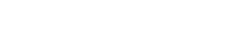

,job_title


In [53]:
glassdoor_scraper(3,'https://www.glassdoor.co.uk/Salaries/london-data-scientist-salary-SRCH_IL.0,6_IM1035_KO7,21_IP{}.htm')

In [ ]:
<div class="row align-items-center m-0 salaryRow__SalaryRowStyle__row"><div class="col-md-6 px-0 py-sm py-md-std"><div class="row pl-xsm"><div class="true col-2 p-0"><a href="/Salary/Moneysupermarket-Group-Salaries-E33122.htm"><span class="common__SqLogoStyle__sqLogo common__SqLogoStyle__sm tighten"><img alt="Moneysupermarket Group" class="lazy lazy-loaded sm" src="https://media.glassdoor.com/sql/33122/moneysupermarket-group-squarelogo-1576243612730.png"></span></a></div><div class="salaryRow__JobInfoStyle__employerInfo col-10 pl"><div class="salaryRow__JobInfoStyle__jobTitle strong"><a href="/Salary/Moneysupermarket-Group-Data-Scientist-London-Salaries-EJI_IE33122.0,22_KO23,37_IL.38,44_IM1035.htm">Data Scientist</a></div><div class="salaryRow__JobInfoStyle__employerName">Moneysupermarket Group</div><div class="salaryRow__JobInfoStyle__meanBasePay common__formFactorHelpers__showHH"><span class="strong">£41,076</span>/yr</div><div class="salaryRow__JobInfoStyle__range common__formFactorHelpers__showHH">Range: £35K - £43K</div><div class="salaryRow__JobInfoStyle__jobCount minor">3&nbsp;salaries</div><div class="salaryRow__JobInfoStyle__totalSalaries"><a class="minor" href="/Salary/Moneysupermarket-Group-Data-Scientist-Salaries-E33122_D_KO23,37.htm">See 3 salaries from all locations</a></div></div></div></div><div class="col-2 d-none d-md-block px-0 py salaryRow__SalaryRowStyle__amt"><span class="strong">£41,076</span>/yr</div><div class="col-1 d-none d-md-block px-0 py"></div><div class="col-3 d-none d-md-block px-0 py"><div class="common__RangeBarStyle__rangeBar undefined undefined "><div class=""><div class="common__RangeBarStyle__meanIndicator" style="left: 120px;"></div><div class="common__RangeBarStyle__bar"></div></div><div class="common__RangeBarStyle__values common__flex__justifySpaceBetween common__flex__container "><span>£35K</span><span>£43K</span></div></div></div></div>

In [59]:
from selenium import webdriver
from time import time, sleep

In [77]:
driver = webdriver.Chrome(executable_path='./chromedriver')
driver.get('https://www.glassdoor.co.uk/Salaries/london-data-scientist-salary-SRCH_IL.0,6_IM1035_KO7,21.htm')

firm_names = []
job_titles = []
salaries = []
rating = []

for x in tqdm_notebook(range(1, 10)):
    start = time()
    while time()-start<5:
    #     driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        item_tags = driver.find_elements_by_class_name('salaryRow__SalaryRowStyle__row')

    for item in item_tags:
        try:
            firm_names.append(item.find_element_by_class_name('salaryRow__JobInfoStyle__employerName').text)
        except:
            pass

        try:
            job_titles.append(item.find_element_by_class_name('salaryRow__JobInfoStyle__jobTitle').text)
        except:
            pass

        try:
            salaries.append(item.find_element_by_class_name('salaryRow__SalaryRowStyle__amt').text)
        except:
            pass

        try:
            rating.append(item.find_element_by_class_name('salaryRow__JobInfoStyle__jobCount').text)
        except:
            pass

    button = driver.find_element_by_class_name('evidon-banner')
    button.click()
    
items = pd.DataFrame({ 'job_title': job_titles,
                        'firm': firm_names,
                      'avg_salary': salaries,
                     "salary_count": rating
                        })

In [79]:
items


,job_title,firm,avg_salary,salary_count
0,Data Scientist,Barclays,"£53,091/yr",8 salaries
1,Data Scientist,Capgemini,"£56,327/yr",6 salaries
2,Data Scientist,dunnhumby,"£50,516/yr",6 salaries
3,Data Scientist,Tesco,"£50,000/yr",5 salaries
4,Data Scientist,J Sainsbury,"£42,812/yr",5 salaries
5,Data Scientist,Lloyds Banking Group,"£45,935/yr",5 salaries
6,Data Scientist,Capita,"£42,608/yr",4 salaries
7,Data Scientist,Deliveroo,"£72,567/yr",4 salaries
8,Data Scientist,Facebook,"£95,048/yr",4 salaries
9,Data Scientist,iwoca,"£53,951/yr",4 salaries


In [ ]:
<a class="pagination__ArrowStyle__nextArrow  " href="/Salaries/london-data-scientist-salary-SRCH_IL.0,6_IM1035_KO7,21_IP3.htm"><span>KEY NOT FOUND: pagination.next</span></a>

### See the second workbook for modeling! ###